In [1]:
# Standard library imports
import os
import json
import cPickle as pickle

# Additional library imports
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
%matplotlib inline
plt.style.use('seaborn-white')

In [18]:
def read_image(path):
    """Read image int RGB array."""
    im = cv2.imread(path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return im

def summary(filename, structure, im, contours, json_path=None):
    """Generate dictionary of summary informaiton about image segments."""

    center = []
    area = []
    for c in contours:
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        #cv2.circle(im, (cX, cY), 7, (255, 255, 255), -1)
        a = cv2.contourArea(c)
        center.append((cX, cY))
        area.append(a)

    output = { 
        'area': area,
        'center': center,
        'contour_(x,y)': contours,
        'img_file': filename,
        'structure': structure,
    }

    if json_path:
        with open(json_path, 'w') as outfile:
            json.dump(output, outfile, cls=myEncoder)

    return output

In [19]:
def green_cell(im, filename,metadatafilename):
    """Functions to segment green cells."""

    def normalize_image(im):
        """Normalize image."""
        R, G, B = cv2.split(im)    
        G_norm = cv2.normalize(G, G, 0, 175, cv2.NORM_MINMAX)
        im = cv2.merge((R, G_norm, B)) 
        return im

    def call_metadata(filename):
        """Call metadata for the image."""
        df = pd.read_csv(metadatafilename)
        magnification = df[df["img_file"]==filename]["magnification"].any()
        return magnification

    def find_contours(im, magnification):
        """Segment image returning list of segment contours."""

        im_norm = normalize_image(im)
        minArea_20X = 100
        #minArea_20X = 500
        minArea_60X = 200
        if magnification == "20X":
            minArea = minArea_20X
        if magnification == "60X":
            minArea = minArea_60X
        thresh = cv2.inRange(im_norm, np.array([0,55,40]), np.array([60,255,255]))
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
        contours = [c for c in contours if cv2.contourArea(c) > minArea]
        return contours

    def draw_contours(im, contours):
        """Draw contours on image."""

        for i in range(len(contours)):
            cv2.drawContours(im, contours, i, (255,0,50), thickness=5, lineType=2, maxLevel=0)
        return im
    
    im1 = normalize_image(im)
    magnification= call_metadata(filename)
    contours = find_contours(im1, magnification)
    draw_contours(im, contours)
    return contours, im

In [20]:
def acinar_tubule(im, filename,metadatafilename):
    """Functions to segment acinar tubules."""

    def call_metadata(filename):
        """Call metadata for the image."""
        df = pd.read_csv(metadatafilename)
        magnification = df[df["img_file"]==filename]["magnification"].any()
        age = df[df["img_file"]==filename]["age_label"].any()
        color = df[df["img_file"]==filename][df[df["img_file"]==filename]["probe_label"] == "TTF-1"]["color"].any()
        return magnification, age, color

    def normalize_image(im, color):
        """Normalize image."""
        if color == "Red":
            im = im
        else:
            R, G, B = cv2.split(im)    
            G_norm = cv2.normalize(G,G,0, 175, cv2.NORM_MINMAX)
            im = cv2.merge((R, G_norm, B)) 
        return im
    
    def find_contours(im, magnification, color):
        """Segment image returning list of segment contours."""

        im_norm = normalize_image(im, color)
        blur_20X = (33,33)
        blur_60X = (103,103)
        if magnification == "20X":
            blur = blur_20X
            minArea = 300
        if magnification == "60X" or magnification == "100X":
            blur = blur_60X
            minArea = 300
        im_blur = cv2.GaussianBlur(im_norm, blur,0)
        if color == "Red":
            thresh = cv2.inRange(im_blur, np.array([68,0,50]), np.array([255,60,255]))
        elif color == "Green":
            thresh = cv2.inRange(im_blur, np.array([0,65,40]), np.array([60,255,255]))
        else:
            thresh = cv2.inRange(im_blur, np.array([0,55,40]), np.array([60,255,255]))

        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
        contours = [c for c in contours if cv2.contourArea(c) > minArea]
        return contours

    def draw_contours(im, contours):
        """Draw contours on image."""
        if magnification == "20X":
            thick = 8
        if magnification == "60X":
            thick = 14
        if magnification == "100X":
            thick = 18

        for i in range(len(contours)):
            cv2.drawContours(im, contours, i, (255,99,0), thickness=thick, lineType=2, maxLevel=0)
        return im
    
    if "NKX2" in filename or "SOX9" in filename and "E16.5" in filename:
        magnification, age, color = call_metadata(filename)
        im1 = normalize_image(im, color)
        contours = find_contours(im1, magnification, color)
        draw_contours(im, contours)
        return contours, im
    
    else:
        return None, im

In [21]:
def bronchiole(im, filename,metadatafilename):
    """Functions to segment bronchioles."""
    
    def call_metadata(filename):
        """Call metadata for the image."""
        df = pd.read_csv(metadatafilename)
        magnification = df[df["img_file"]==filename]["magnification"].any()
        age = df[df["img_file"]==filename]["age_label"].any()
        return magnification, age
    
    def blur_image(im):
        if age=="E18.5" or age=="P28":
            im = cv2.GaussianBlur(im, (99,99),0)   
        return im
    
    def bronchiolecontours(im, age, magnification):

        origin = im.copy()

        im=blur_image(im)
            
        # find contours
        if magnification == "60X":
            minarea = 9000
        elif magnification == "20X":
            minarea = 3000
            
        finalcontours = []
        imgray = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)
        thresh = cv2.inRange(im, np.array([0,0,0]), np.array([25,25,25]))
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
        for i in range(0, len(contours)):
            a = cv2.contourArea(contours[i])
            if (a>minarea):
                finalcontours.append(contours[i])
        

        bronchiolecontours=[]
        
        for ct in finalcontours:
                
            a = cv2.contourArea(ct)
            if a>375000:
                T=75
            elif a>200000:
                T= int(a*0.0002)
            else:
                T=50
            mask = np.zeros(imgray.shape,np.uint8)
            temp2 = cv2.drawContours(mask,ct,0,(100,100,100),thickness=T, lineType=2,maxLevel = 0)

            cv2.drawContours(mask,[ct],0,0,-1)#delete the contour area from the mask
            mean_val = cv2.mean(origin,mask = mask)
                
            if (age=="E16.5" and mean_val[0]>10 and mean_val[1]>30 and mean_val[2]>30 and mean_val[0]<50) or \
                (age=="E18.5" and (mean_val[2]-10>mean_val[0] and mean_val[1]>mean_val[0])  and mean_val[0]<35) or \
                (age=="P28" and mean_val[0]<20 and mean_val[1]>20):
                bronchiolecontours.append(ct)
        return bronchiolecontours
    
    def draw_contours(im, contours):
        """Draw contours on image."""

        for i in range(len(contours)):
            cv2.drawContours(im, contours, i, (250,220,55), thickness=8, lineType=2, maxLevel=0)
        return im

    magnification, age = call_metadata(filename)
    contours = bronchiolecontours(im, age, magnification)
    draw_contours(im, contours)
    return contours, im

In [22]:
def vein(im, filename,metadatafilename):
    """Functions to segment bronchioles."""
    
    def call_metadata(filename):
        """Call metadata for the image."""
        df = pd.read_csv(metadatafilename)
        magnification = df[df["img_file"]==filename]["magnification"].any()
        age = df[df["img_file"]==filename]["age_label"].any()
        return magnification, age
    
    def normalize_image(im):
        """Normalize image."""
        R, G, B = cv2.split(im)    
        G_norm = cv2.normalize(G, G, 0, 175, cv2.NORM_MINMAX)
        im = cv2.merge((R, G_norm, B)) 
        return im
    
    def blur_image(im):
        if age=="E18.5" or age=="P28":
            im = cv2.GaussianBlur(im, (99,99),0)   
        return im
        
    def vein_contours(im, age, magnification):
        #im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        origin = im.copy() 
            
        im=blur_image(im)
        imgray = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)
        # find contours
        if magnification == "60X":
            minarea = 9000
        elif magnification == "20X":
            minarea = 3000
            
        finalcontours = []
        thresh = cv2.inRange(im, np.array([0,0,0]), np.array([25,25,25]))
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
        for i in range(0, len(contours)):
            a = cv2.contourArea(contours[i])
            if (a>minarea):
                finalcontours.append(contours[i])
        

        vein_contours=[]
        
        for ct in finalcontours:
                
            a = cv2.contourArea(ct)
            if a>375000:
                T=75
            elif a>200000:
                T= int(a*0.0002)
            else:
                T=50
            mask = np.zeros(imgray.shape,np.uint8)
            cv2.drawContours(mask,[ct],0,(100,100,100),thickness=T, lineType=2,maxLevel = 0)

            cv2.drawContours(mask,[ct],0,0,-1)#delete the contour area from the mask
            mean_val = cv2.mean(origin,mask = mask)
                
            if  (age=="E16.5" and (np.mean(mean_val)>40 and not ((mean_val[2]-10>mean_val[0] and mean_val[1]>mean_val[0])  and mean_val[0]<35))) or \
                (age== "E18.5" and (np.mean(mean_val)>40 or min([mean_val[0],mean_val[1],mean_val[2]])>45)):
                vein_contours.append(ct)
        return vein_contours
    
    def draw_contours(im, contours):
        """Draw contours on image."""

        for i in range(len(contours)):
            cv2.drawContours(im, contours, i, (50,250,55), thickness=10, lineType=2, maxLevel=0)
        return im

    #im1 = normalize_image(im)
    magnification, age = call_metadata(filename)
    contours = vein_contours(im, age, magnification)
    draw_contours(im, contours)
    return contours, im

In [26]:
def TTF1_cells(im, filename,metadatafilename):
    """Functions to segment TTF1 marked cells."""
    
    def call_metadata(filename):
        """Call metadata for the image."""
        df = pd.read_csv(metadatafilename)
        magnification = df[df["img_file"]==filename]["magnification"].any()
        color = df[df["img_file"]==filename][df[df["img_file"]==filename]["probe_label"] == "TTF-1"]["color"].any()
        return magnification, color

    def normalize_image(im, color):
        """Normalize image."""
        if color == "Green":
            R, G, B = cv2.split(im)    
            G_norm = cv2.normalize(G,G,0, 175, cv2.NORM_MINMAX)
            im = cv2.merge((R, G_norm, B)) 
        elif color == "Red":
            im = im
        return im
    
    def find_contours(im, magnification, color):
        """Segment image returning list of segment contours."""

        im_norm = normalize_image(im, color)
        minArea_20X = 20
        minArea_60X = 200
        minArea_100X = 500

        if magnification == "20X":
            minArea = minArea_20X
        if magnification == "60X":
            minArea = minArea_60X
        if magnification == "100X":
            minArea = minArea_100X
         
        if color == "Green":
            thresh = cv2.inRange(im, np.array([0,55,40]), np.array([60,255,255]))
        elif color == "Red":
            thresh = cv2.inRange(im, np.array([68,0,50]), np.array([255,60,255]))
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
        contours = [c for c in contours if cv2.contourArea(c) > minArea]
        return contours
    
    def draw_contours(im, contours):
        """Draw contours on image."""
        if magnification == "20X":
            thick = 2
        if magnification == "60X":
            thick = 10
        if magnification == "100X":
            thick = 14
 
        for i in range(len(contours)):
            cv2.drawContours(im, contours, i, (255,200,15), thickness=thick, lineType=2, maxLevel=0)
        return im

    if "NKX2" in filename:
        magnification, color = call_metadata(filename)
        im1 = normalize_image(im, color)
        contours = find_contours(im1, magnification, color)
        draw_contours(im, contours)
        return contours, im
    
    else:
        return None, im
    

In [24]:
def club_cell(im, filename,metadatafilename):
    """Functions to segment red cells."""

    def call_metadata(filename):
        """Call metadata for the image."""
        df = pd.read_csv(metadatafilename)
        magnification = df[df["img_file"]==filename]["magnification"].any()
        return magnification

    def normalize_image(im):
        """Normalize image."""
        R, G, B = cv2.split(im)    
        R_norm = cv2.normalize(R, R, 50, 255, cv2.NORM_MINMAX)
        im = cv2.merge((R_norm, G, B)) 
        return im

    def find_contours(im, magnification):
        """Segment image returning list of segment contours."""

        im_norm = normalize_image(im)
        minArea_20X = 200
        minArea_60X = 250
        minArea_100X = 300
        blur_20X = (33,33)
        blur_60X = (73,73)
        blur_100X = (103,103)

        if magnification == "20X":
            minArea = minArea_20X
            blur = blur_20X
        if magnification == "60X":
            minArea = minArea_60X
            blur = blur_60X
        if magnification == "100X":
            minArea = minArea_100X
            blur = blur_100X
            
        im_blur = cv2.GaussianBlur(im_norm, blur,0)

        thresh = cv2.inRange(im_blur, np.array([93,0,0]), np.array([255,50,100]))
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
        contours = [c for c in contours if cv2.contourArea(c) > minArea]
        return contours

    def draw_contours(im, contours):
        """Draw contours on image."""
        if magnification == "20X":
            thick = 8
        if magnification == "60X":
            thick = 10
        if magnification == "100X":
            thick = 12
 
        for i in range(len(contours)):
            cv2.drawContours(im, contours, i, (250,220,55), thickness=thick, lineType=2, maxLevel=0)
        return im

    if "SCGB1" in filename:
        im1 = normalize_image(im)
        magnification = call_metadata(filename)
        contours = find_contours(im1, magnification)
        draw_contours(im, contours)
        return contours, im
    
    else:
        im1 = normalize_image(im)
        return None, im
    

In [27]:
# only one for now, but you can add more by creating more rules as in `green_cell()` above

rules = {
    'green_cells': green_cell,
    'acinar_tubules': acinar_tubule,
    'veins': vein,
    'bronchioles': bronchiole,
    'TTF1_cells': TTF1_cells,
    'club_cells': club_cell
}

In [19]:
# save segmentated images (acinar_tubule in this example) to pdf
with PdfPages('./output/segmentation_AcinarTubule3.pdf') as pdf:

    for subdir, dirs, files in os.walk('G:/2016/Summer/LungMAP/Image_data'):
        for file in files:
            filepath = subdir + os.sep + file
            if "LMH" not in filepath and "meta.json" not in filepath and "E16.5" in filepath and ("NKX2" in filepath or "SOX9" in filepath):
                im = read_image(filepath)
                im0 = read_image(filepath)
                contours, im_out = acinar_tubule(im, file)
                fig, axes = plt.subplots(1, 2, figsize=(18,9))
                plt.title(file)
                for ax, im in zip(axes, [im0, im_out]):
                    ax.imshow(im)
                    ax.set_xticks([])
                    ax.set_yticks([])
                pdf.savefig()
                plt.close()

In [44]:
#test segmentation results with one sample image
base_dir = './images'
filename = '2015-002-019_60X_C57Bl6_PND7_LMM.15.17A.5.14_NKX2.1_SCGB1A1_TUBA1A_004.tif'
metadatafilename='C:\\Users\\Lina\\Anaconda3\\notebook\\data\\metadata\\metadata_table_all.csv'
path = os.path.join(base_dir, filename)
im = read_image(path)
im0 = read_image(path)


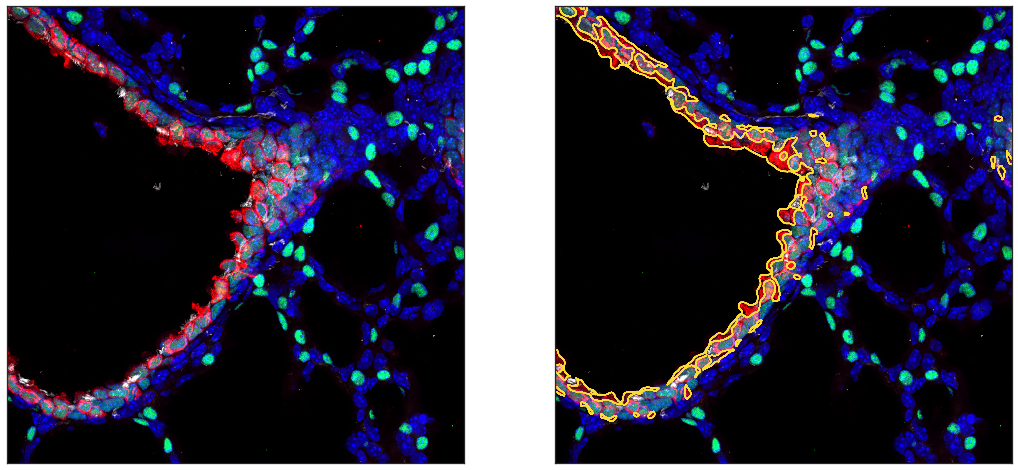

In [45]:
# example to show club_cell segmentation
contours, im_test = club_cell(im, filename,metadatafilename)
fig, axes = plt.subplots(1, 2, figsize=(18,9))
for ax, im in zip(axes, [im0, im_test]):
    ax.imshow(im)
    ax.set_xticks([])
    ax.set_yticks([])